In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
# Wofs imports
import gc
import collections

from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask

from PIL import Image
import rasterio
import os

## Limpieza de datos

Para optimizar el entrenamiento y el testeo de los datos se cambia el valor de todo pixel con nubes a 9999. De esta forma, el pixel es excluido del entrenamiento y el testeo de los modelos. Esto permite reducir la cantidad de datos a solo las characteristicas del suelo y el agua. Se realiza este filtrado utilizando el mapa de nubes ofrecido por USGS presente en la banda 

### Cloud mask

In [2]:
def cloud_mask(band_data_array,band_pixel_qa):
    """
    Enmascara o hace igual a NaN aquellos pixeles que no son 
    relevantes para el análisis, como aquellos pixeles donde se
    presentan nubes, nieve en todas sus modalidades.
    """
    
    nodata=-9999
    
    # VALORES VALIDOS PARA ANALISIS PRESENTES EN 
    # LA BANDA PIXEL_QA
    
    # Para este caso únicamente nos interesa conservar 
    # aquellos pixeles cuya obvercación es clara y 
    # además pixeles que pueden mostrar información 
    # acerca del agua
    clear = [322, 386, 834, 898, 1346]
    water = [324, 388, 836, 900, 1348]
    valid_values = clear + water

    # Aquellos pixeles cuyos valor esten en valid_values tendran un
    # valor de True en la corrspondiente posición en la matrix mask_1 
    # indicando que son pixeles validos para analisis. Aquellos pixeles 
    # cuyos valores no esten en valid_values tendran un valor de False 
    # en mask_1.
    mask_1 = np.isin(band_pixel_qa.values, valid_values)

    # Marca como True aquellos pixeles que tienen información, es decir, 
    # no son igual a nodata=-9999.
    has_information = band_data_array != nodata

    # Aquellos pixeles que tienen información (has_information[i][j] = True)
    # y son pixeles validos mask_1[i][j] = True, seguirán siendo válidos, es
    # decir, mask_2[i][j] = True. En caso contrarion mask_2[i][j] = False.
    mask_2 = np.logical_and(has_information,mask_1)

    # Para pixeles validos mask_2[i][j] = True, entonces 
    # new_band_data_array[i][j] = band_data_array[i][j]. 
    # En caso contrario, new_band_data_array[i][j] = NaN.
    new_band_data_array = np.where(mask_2,band_data_array,np.nan)
    return new_band_data_array

### NDVI

In [3]:
def ndvi(xarr0):

    # Obteniendo los valores de las bandas. 
    # los valores son np.array
    period_red = xarr0["red"].values
    period_nir = xarr0["nir"].values

    # Si los pixeles en 'red' o 'nir' tiene valoes NaN entonces 
    # mask_nan = True
    mask_nan=np.logical_or(np.isnan(period_red), np.isnan(period_nir))

    # NDVI computation
    period_nvdi = (period_nir-period_red) / (period_nir+period_red)

    # Remover pixeles invalidos
    period_nvdi[mask_nan] = np.nan

    # Remover valores mayores de 1 e inferiores a -1
    # Ya que el indice está definido entre -1 y 1.
    period_nvdi[period_nvdi>1] = np.nan
    period_nvdi[period_nvdi<-1] = np.nan

    data_array = xr.DataArray(data=period_nvdi)
    return data_array

In [4]:
def forest_noForest(ndvi_data_og):
    ndvi_data = ndvi_data_og.copy(deep=True)
    # Dado que bosque no bosque es una clasificación
    # binaria, los valores son número enteros 
    # por lo tanto nodata no puede ser igual a NaN
    nodata = -9999

#     ndvi_data.reindex(y=list(reversed(ndvi_data.y)))
    ndvi_data = ndvi_data.squeeze(['dim_0'])
    nvdi_array = ndvi_data.values

    # Umbral de Bosque
    ndvi_threshold = 0.7

    # Tasa de Vegetación 
    vegetation_rate = 0.3

    # Tamaño de Ventana
    slice_size = 2

    height = nvdi_array.shape[0]
    width = nvdi_array.shape[1]
    bosque_nobosque=np.full(nvdi_array.shape, -1)
    for y1 in range(0, height, slice_size):
        for x1 in range(0, width, slice_size):
            x2 = x1 + slice_size
            y2 = y1 + slice_size
            if(x2 > width):
                x2 = width
            if(y2 > height):
                y2 = height
            submatrix = nvdi_array[y1:y2,x1:x2]
            ok_pixels = np.count_nonzero(~np.isnan(submatrix))
            if ok_pixels==0:
                bosque_nobosque[y1:y2,x1:x2] = nodata
            elif np.nansum(submatrix>ndvi_threshold)/ok_pixels >= vegetation_rate :
                bosque_nobosque[y1:y2,x1:x2] = 1
            else:
                bosque_nobosque[y1:y2,x1:x2] = 0

    # Los valores que son iguales a nodata=-9999 los 
    # los convertimos a 0 (no bosque)
    mask_nan=np.isin(bosque_nobosque,[nodata])
    bosque_nobosque[mask_nan] = 0

    data_array_bosque = xr.DataArray(data=bosque_nobosque)
    return data_array_bosque

### WOFS

In [5]:
def wofs_classify(dataset_in, clean_mask=None, no_data=-9999, enforce_float64=False):
    """
    Description:
      Performs WOfS algorithm on given dataset. If no clean mask is given, the 'cf_mask'
      variable must be included in the input dataset, as it will be used to create a 
      clean mask
    Assumption:
      - The WOfS algorithm is defined for Landsat 5/Landsat 7 
    References:
      - Mueller, et al. (2015) "Water observations from space: Mapping surface water from 
        25 years of Landsat imagery across Australia." Remote Sensing of Environment.
      - https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py
    -----
    Inputs:
      dataset_in (xarray.Dataset) - dataset retrieved from the Data Cube; should contain
        coordinates: time, latitude, longitude
        variables: blue, green, red, nir, swir1, swir2
        If user does not provide a clean_mask, dataset_in must also include the cf_mask
        variable
    Optional Inputs:
      clean_mask (nd numpy array with dtype boolean) - true for values user considers clean;
        if user does not provide a clean mask, one will be created using cfmask
      no_data (int/float) - no data pixel value; default: -9999
      enforce_float64 (boolean) - flag to indicate whether or not to enforce float64 calculations;
        will use float32 if false
    Output:
      dataset_out (xarray.DataArray) - wofs water classification results: 0 - not water; 1 - water
    """
    
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)
        
    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Regression analysis based on Australia's training data
        TODO: Return type
        """
        
        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)
        
        #classified = np.ones(shape, dtype='uint8')
        
        classified = np.full(shape, no_data)
      
        # Start with the tree's left branch, finishing nodes as needed
        
        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0 #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1 #Node 6
        classified[_tmp2 & ~r4] = 0 #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1 #Node 10
        classified[_tmp2 & ~r6] = 0 #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1 #Node 14
        classified[_tmp2 & ~r8] = 0 #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1 #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1 #Node 19
        classified[_tmp & ~r10] = 0 #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()
        
        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0 #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0 #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1 #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1 #Node 31
        classified[_tmp2 & ~r16] = 0 #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1 #Node 33
        classified[_tmp2] = 0 #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0 #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0 #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0 #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0 #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1 #Node 44
        classified[_tmp & ~r22] = 0 #Node 45

        # Completed regression tree
        
        return classified
    
    # Extract dataset bands needed for calculations
    blue = dataset_in["blue"]
    green = dataset_in["green"]
    red = dataset_in["red"]
    nir = dataset_in["nir"]
    swir1 = dataset_in["swir1"]
    swir2 = dataset_in["swir2"]
    
    # Enforce float calculations - float64 if user specified, otherwise float32 will do
    dtype = blue.values.dtype # This assumes all dataset bands will have
                              # the same dtype (should be a reasonable
                              # assumption)

    if enforce_float64:
        if dtype != 'float64':
            blue.values = blue.values.astype('float64')
            green.values = green.values.astype('float64')
            red.values = red.values.astype('float64')
            nir.values = nir.values.astype('float64')
            swir1.values = swir1.values.astype('float64')
            swir2.values = swir2.values.astype('float64')
    else:
        if dtype == 'float64':
            pass
        elif dtype != 'float32':
            blue.values = blue.values.astype('float32')
            green.values = green.values.astype('float32')
            red.values = red.values.astype('float32')
            nir.values = nir.values.astype('float32')
            swir1.values = swir1.values.astype('float32')
            swir2.values = swir2.values.astype('float32')
    
    shape = blue.values.shape
    classified = _run_regression(blue.values, green.values, red.values, 
                                 nir.values, swir1.values, swir2.values)

    classified_clean = np.full(classified.shape, no_data)
    classified_clean[clean_mask] = classified[clean_mask] # Contains data for clear pixels
    dataset_out = xr.DataArray(classified_clean)
    return dataset_out

In [6]:
img_folder_list = os.listdir("./data/")
current_img_dict = {}
for img_folder in img_folder_list:
    img_list = os.listdir("./data/"+img_folder+"/")
    for img in img_list:
        print(img)
        if img.endswith(".tif"):
            sat_img = xr.open_rasterio("./data/"+img_folder+"/"+img)
            if "band2" in img:
                current_img_dict["blue"] = sat_img
            elif "band3" in img:
                current_img_dict["green"] = sat_img
            elif "band4" in img:
                current_img_dict["red"] = sat_img
            elif "band5" in img:
                current_img_dict["nir"] = sat_img
            elif "band6" in img:
                current_img_dict["swir1"] = sat_img
            elif "band7" in img:
                current_img_dict["swir2"] = sat_img
            elif "pixel_qa" in img:
                current_img_dict["pixel_qa"] = sat_img

LC08_L1TP_004063_20150820_20170406_01_T2_MTL.txt
LC08_L1TP_004063_20150820_20170406_01_T2_ANG.txt
LC08_L1TP_004063_20150820_20170406_01_T2.xml
LC08_L1TP_004063_20150820_20170406_01_T2_pixel_qa.tif
LC08_L1TP_004063_20150820_20170406_01_T2_sr_band1.tif
LC08_L1TP_004063_20150820_20170406_01_T2_sr_aerosol.tif
LC08_L1TP_004063_20150820_20170406_01_T2_radsat_qa.tif
LC08_L1TP_004063_20150820_20170406_01_T2_sr_band7.tif
LC08_L1TP_004063_20150820_20170406_01_T2_sr_band5.tif
LC08_L1TP_004063_20150820_20170406_01_T2_sr_band2.tif
LC08_L1TP_004063_20150820_20170406_01_T2_sr_band6.tif
LC08_L1TP_004063_20150820_20170406_01_T2_sr_band3.tif
LC08_L1TP_004063_20150820_20170406_01_T2_sr_band4.tif
LC08_L1TP_009059_20160825_20170322_01_T1.xml
LC08_L1TP_009059_20160825_20170322_01_T1_radsat_qa.tif
LC08_L1TP_009059_20160825_20170322_01_T1_sr_band3.tif
LC08_L1TP_009059_20160825_20170322_01_T1_sr_band6.tif
LC08_L1TP_009059_20160825_20170322_01_T1_sr_band7.tif
LC08_L1TP_009059_20160825_20170322_01_T1_sr_band2.ti

In [7]:
bands = ['blue','green','red','nir','swir1','swir2']
for band in bands:
    current_img_dict[band].values = cloud_mask(
        band_data_array=current_img_dict[band],
        band_pixel_qa=current_img_dict['pixel_qa']
    )

In [8]:
wofs_results = wofs_classify(current_img_dict)
current_img_dict["wofs"] = wofs_results

/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in divide
/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less_equal
/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less_equal
/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less_equal
/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid val

In [9]:
#wofs_results.plot()

In [10]:
# show(wofs_results)
wofs_results

<xarray.DataArray (dim_0: 1, dim_1: 7761, dim_2: 7611)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

In [11]:
ndvi_results = ndvi(current_img_dict)

/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


In [12]:
# ndvi_results.plot()
ndvi_results

<xarray.DataArray (dim_0: 1, dim_1: 7761, dim_2: 7611)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

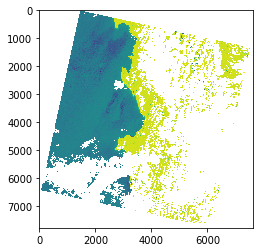

In [13]:
show(ndvi_results)

In [14]:
forest_noForest_results = forest_noForest(ndvi_results)
current_img_dict["forest_noForest"] = forest_noForest_results

/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


In [15]:
# show(forest_noForest_results)

In [16]:
for pair in current_img_dict.items():
    pair[1] = pair[1].squeeze(['dim_0'])
data_lists = []
image_shape = current_img_dict["blue"].shape
for i in range(0,image_shape[0]):
    new_list = []
    data_lists.append(new_list)
    for j in range(0,image_shape[1]):
        data_lists.append(current_img_dict["blue"].values[i,j])
        


KeyError: 'dim_0'